In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pymc as pm
from scipy.integrate import odeint
from time import clock, sleep
from datetime import datetime as dt
from pprint import pprint
import pickle
from pertussis import *

# # Initial
r_start = 1920
r_end = 2015
step = 1 / N
t_end = expand_time(r_end, start=r_start, step=step)
t_start = expand_time(r_start, start=r_start, step=step)
t_range = np.arange(t_start, t_end, 1)

# Data
data = cases_month_age()

# Parameters
state_0 = collect_state0()
state_0 = pack_flat(state_0)

#######################
###### Run Model ######
#######################

# Priors
o = pm.Uniform('omega', 3, 6)
p = pm.Uniform('phi', 0, o + 0.1)
# o = 4
# p = 0
f_top = 25
f1 = pm.Uniform('f1', 0, f_top)
f2 = pm.Uniform('f2', 0, f_top)
f3 = pm.Uniform('f3', 0, f_top)
p = pm.Uniform('p', 1/400, 1/60)

@pm.deterministic
def f(f1=f1, f2=f2, f3=f3):
    s1, s2 = 4, 3
    s3 = J - s1 - s2
    return np.concatenate((nums(f1, s1), nums(f2, s2), nums(f3, s3)))


# times = []


@pm.deterministic
def sim(o=o, p=p, f=f, z=z):
    res = odeint(hetro_model, pack_flat(state_0), t_range,
                 args=(o, p, f, z, r_start))

    res = unpack(res.T, *unpack_values)
    return res


@pm.deterministic
def mu1(sim=sim, o=o, p=p, f=f, z=z):
    x = reduce_time(t_range, start=r_start, step=step)
    y = new_cases(x, sim[0], sim[1], sim[2], sim[3], sim[4], f=f, zeta=z, o=o, p=o)
    start_ix = (1998 - r_start) * 12
    end_ix = (2014 - r_start) * 12
    res = reduce_month(y)[:,start_ix:end_ix]
#     print (res.shape)
    return res


# def mu2(sim=sim):
#     ...

# TODO: Two sigmas
sigma1 = pm.Uniform('sigma1', 0, 0.5)
# sigma2 = pm.Uniform('sigma2', 0, sigma1/12)


Y1 = pm.Normal('Y1', mu=mu1, tau=1 / sigma1 ** 2, observed=True, value=data)
# Y2 = pm.Normal('Y2', mu=mu2, tau=1 / sigma2 ** 2, observed=True, value=data_monthly)

# TODO: Set weights

# model = pm.Model([Y1, o, p, sim, f, f1, f2, f3, mu1, sigma1, s0, i0, state_0, z])
model = pm.Model([Y1, sim, f, mu1, sigma1, o, p, z, f1, f2, f3, ])
# model = pm.Model([Y1, sim, f, mu1, sigma1, z, f1, f2, f3])

In [36]:
Y2 = pm.Binomial('Y2', n=mu1, p=p, observed=True, value=data )

## Load Existing model

In [2]:
try:
    del(mcmc)
except:
    pass

name = "db.p"
path = "./mcmc/{}".format(name)

try:
    db = pm.database.pickle.load(path)
    mcmc = pm.MCMC(model, db=db)
    print ("Continuing chains from previous simulations. If you wish restart delete the relevant pickle or change the name")
except:
    mcmc = pm.MCMC(model, db="pickle", dbname=path)
    print (mcmc.db)
    print ("Creating new db")

Creating new db


In [3]:
mcmc.sample(iter=2, burn=0)  #######################################################################################
mcmc.db.close()

 [--------------------------150%---------------------------] 3 of 2 complete in 31.5 sec

In [30]:
# list(model.stochastics)
# for var in mcmc.stochastics:
#     print (var)
#     print(mcmc.trace(var)[:].mean())
mcmc.write_csv('./output/temp.csv', variables = [str(v) for v in mcmc.stochastics])

c:\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:225: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)


In [33]:
mcmc.db.close()
t_tally = 0
m_f = mcmc.trace('f', chain=None)[t_tally:].mean(axis=0)
m_o = mcmc.trace('omega', chain=None)[t_tally:].mean()
m_p = mcmc.trace('phi', chain=None)[t_tally:].mean()
# m_o = 4
# m_p = 0
m_z = mcmc.trace('zeta', chain=None)[t_tally:].mean()
m_mu = mcmc.trace('mu1', chain=None)[:].mean(axis=0)

In [34]:
mcmc.trace('mu1', chain=None)[:].shape

(2, 11, 192)

In [58]:
from scipy.stats.mstats import mquantiles
tr_mu = mcmc.trace('mu1')#[:,1,:]
# quants = mquantiles(tr_mu, prob=[0.05,0.95], axis=0)
# quants.shape
# tr_mu.shape#.mean(axis=0)

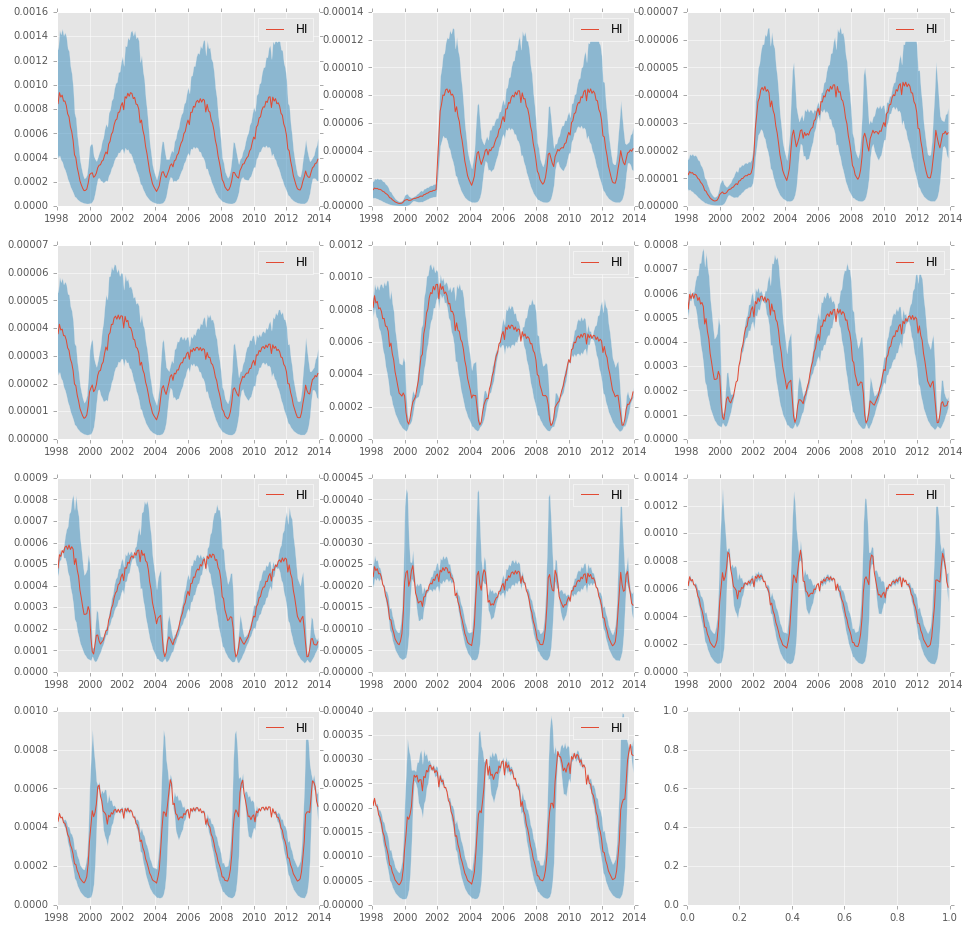

In [78]:
fig, axs = plt.subplots(4,3, figsize=(16,16))
axs = np.hstack(axs)
axs
x = 1998 + np.arange(0,192,1) / 12
for i in range(J):
    ax = axs[i]
    q_mu = tr_mu[:,i,:]
    quants = mquantiles(q_mu, prob=[0.05,0.95], axis=0)
#     print (q_mu.shape)
    ax.fill_between(x,quants[0],quants[-1], alpha = 0.5)
    ax.plot(x, q_mu.mean(axis=0), label="HI")
#     ax.plot(x, quants[0])
#     ax.plot(x, quants[1])
    ax.legend(loc='best')


IndexError: too many indices for array

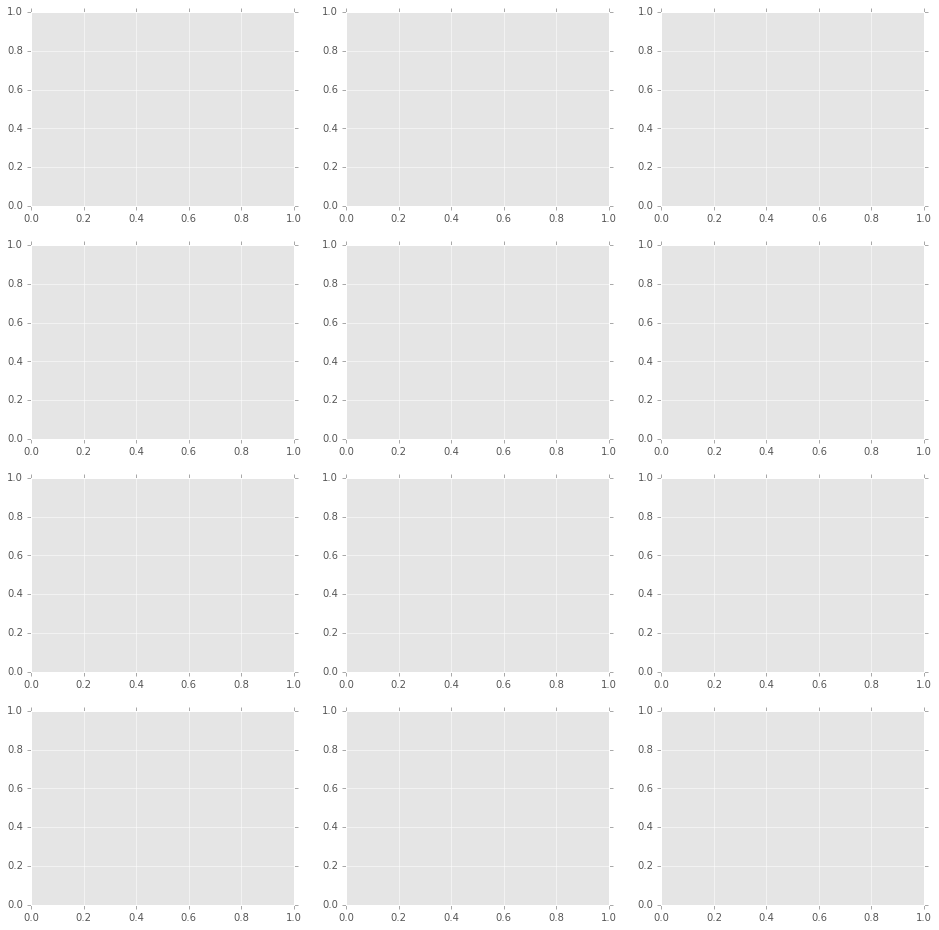

In [54]:
fig, axs = plt.subplots(4,3, figsize=(16,16))
axs = np.hstack(axs)
axs
x = 1998 + np.arange(0,192,1) / 12
for i in range(J):
    
    quants = mquantiles(mu[:, i, :], prob=[0.05,0.95], axis=0)
    print (quants[0])
    axs[i].plot(x,m_mu[i,:], label = 'Model')
    axs[i].plot(x,data[i,:], '--', label = "Data")
    axs[i].set_title('Age: {:.2f} - {:.2f}'.format(a_l[i],a_u[i]))
    axs[i].fill
    axs[i].legend()
plt.tight_layout()

ODE Time:  3.48273994070536


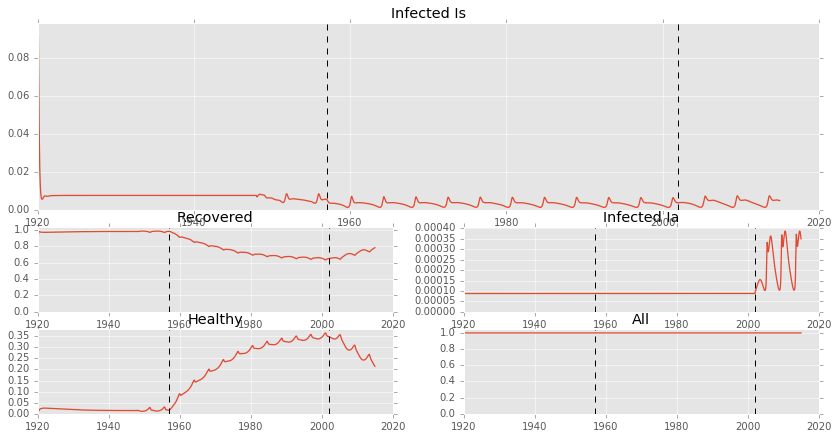

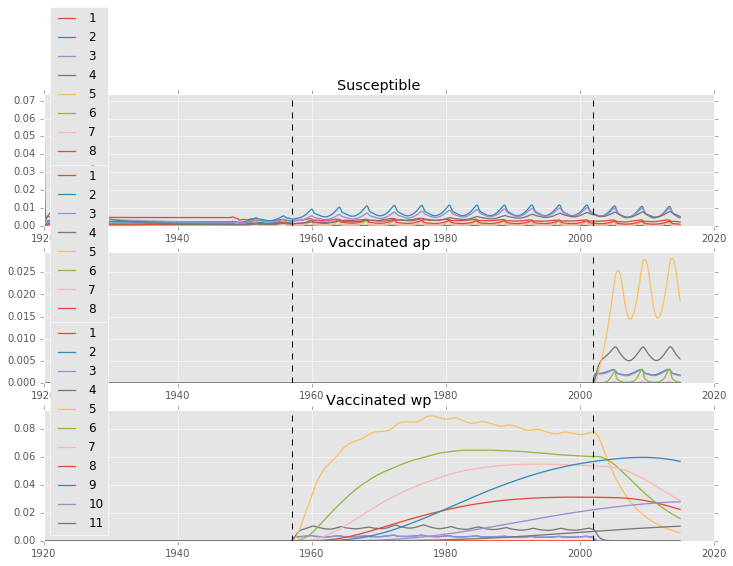

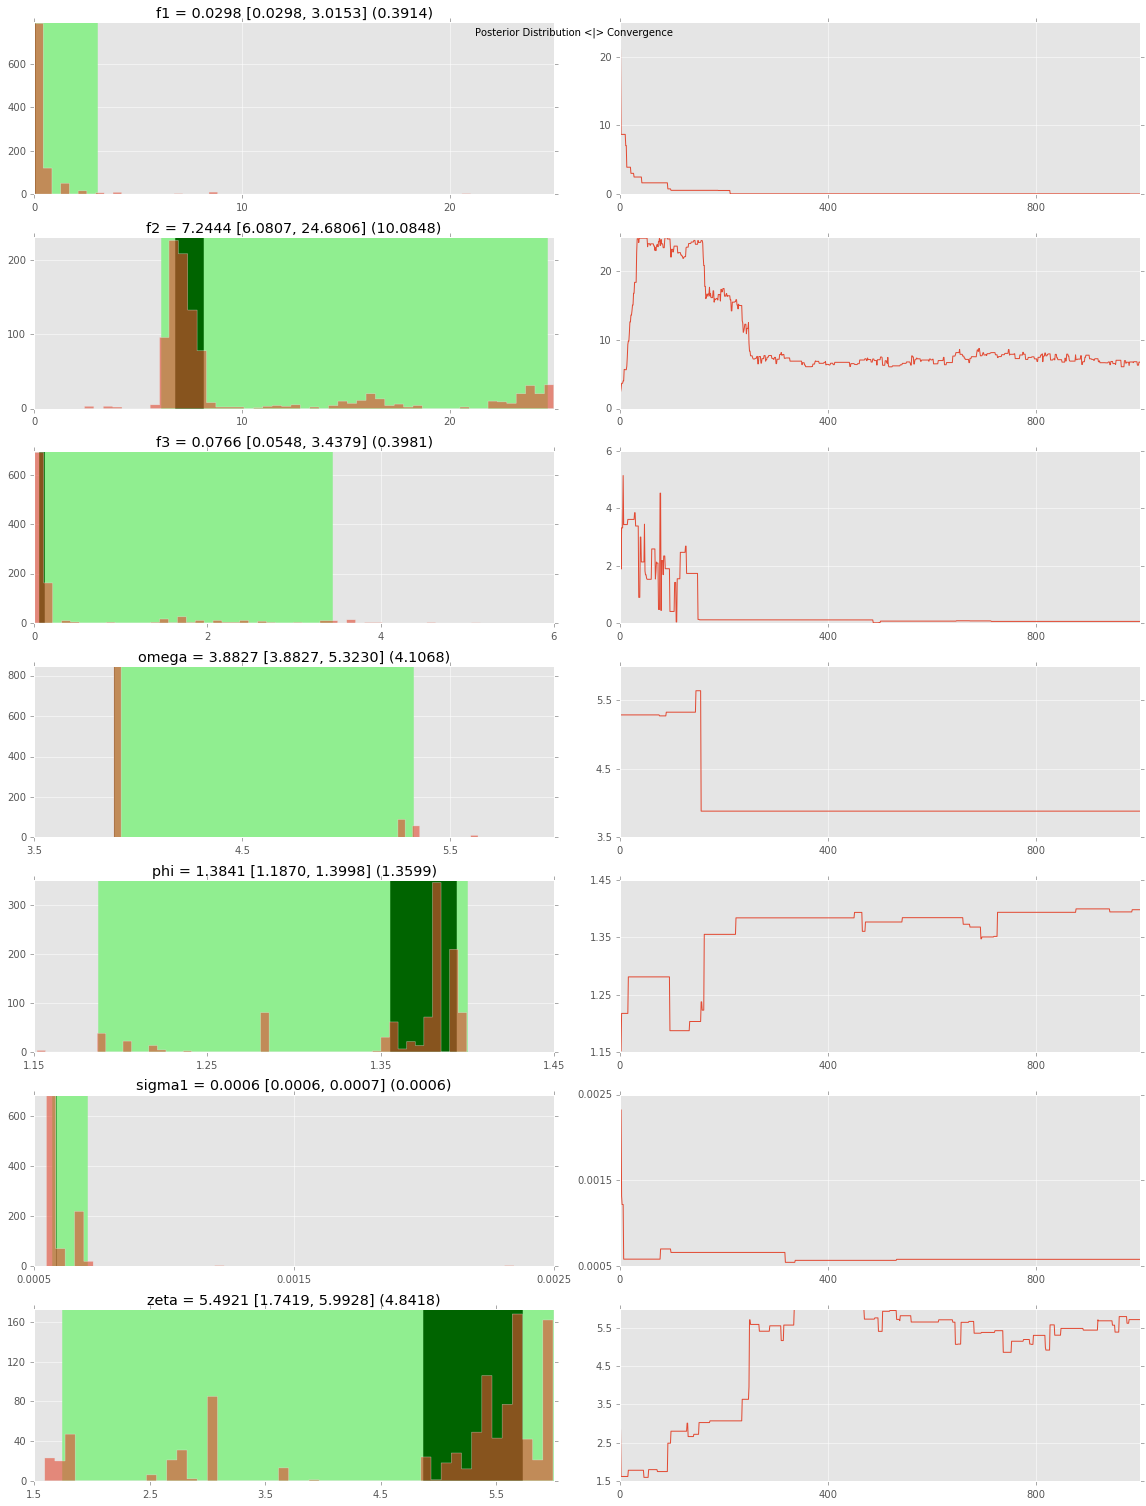

In [32]:
# Show mean values fit
clk = clock()
RES = odeint(hetro_model, state_0, t_range,
             args=(m_o, m_p, m_f, m_z, r_start))
print("ODE Time: ",clock() - clk)
# # Results
x = reduce_time(t_range, start=r_start, step=step)
y = unpack(RES.T, *unpack_values)
h = sum([i for i in y[:3]])
all = sum([i for i in y])
y.append(h)
y.append(all)

# PLOT
# print (m_mu)
fig1, ax1 = draw_model(x, y[3:], ["Infected Is", "Infected Ia", "Recovered", "Healthy", "All"], split=0, collapse=True)
# fig3, ax3 = draw_model(x, [m_mu], ["Infected Is", "Infected Ia", "Recovered", "Healthy", "All"], split=0, collapse=True)
fig2, ax2 = draw_model(x, y[0:3], ["Susceptible", "Vaccinated ap", "Vaccinated wp"], split=False, collapse=False)
# ax1[0].scatter(years, data_years / 12)
# ax1[0].scatter(months, data_months, c='green')
# ax1[0].set_xlim([2000,2015])
fig4, ax4 = plot_stoch_vars(mcmc)
fig4.savefig('./img/mcmc{}.png'.format(dt.utcnow()).replace(':', '-'))
# for ax in ax3:
#     ax.set_xlim(1955, 2013)
# ax3[0].set_ylim(0, 0.05)

plt.tight_layout()
plt.show()